In [1]:
# Initialize Otter
import otter
grader = otter.Notebook()

# Lab 13: Using the Bootstrap for Estimation
**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your solution.

## Due Date

This assignment is due on **Monday, December 7th, at 11:59PM.**

## Introduction

In this lab, you will examine the bootstrap in greater detail. The goal is to develop a functional approach to bootstrapping any statistic for any sample.

**Collaborators:** *list names here*

## Disclaimer about `sns.distplot()`

This lab was designed for a slightly older version of seaborn, which does not support the new `displot` method taught in Lecture 9. Instead, in this lab, we will occasionally call `distplot` (with a `t`). As you may have noticed in several of the previous assignments, use of the `distplot` function triggers a deprecation warning to notify the user that they should replace all deprecated functions with the updated version. Generally, warnings should not be suppressed but we will do so in this assignment to avoid cluttering.

See the seaborn documentation on [distributions](https://seaborn.pydata.org/tutorial/distributions.html) and [functions](https://seaborn.pydata.org/tutorial/function_overview.html) for more details.

In [2]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Run this cell to set up your notebook

import seaborn as sns
import csv
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import scipy.stats
sns.set()

## The Bootstrap Procedure

The bootstrap is a very simple process: 
* Sample with replacement from the original sample (now the **bootstrap population**). These samples are called **bootstrap samples**. We typically take thousands of bootstrap samples (~10,000 is common).
* Calculate the statistic of interest for each bootstrap sample. This statistic is called the **bootstrap statistic**, and the empirical distribution of these bootstrap statistics is an approximation to the **sampling distribution** of the bootstrapped statistic.

But why bootstrap instead of just calculating the statistic of interest once on the whole sample? 

Take sample mean estimator as an example. Suppose $\{x_i\}$ are samples coming from an unknown distribution. We can use sample mean $\bar{X} = \frac{1}{n}\sum_{i=1}^n x_i$ to estimate the the mean of the population. However, if we obtain another sample set $\{x_i\}$, we can get very different results. Therefore, computing the sampling distribution (distribution of the sample mean for all possible sample sets) would be very helpful. From such a distribution, we can obtain the variance of the estimator: $E[(E(\bar{X})-\bar{X})^2]$.

In order to compute the sampling distribution of $\bar{X}$, we could directly use sampling methods. But that requires us to obtain several different sets of samples $\{x_i\}$ directly from the population. If we have $m$ sets of samples and each set contains $n$ subjects (totaling $m \cdot n$ subjects), we can then use $\hat{X} = \frac{1}{m}\sum_{j=1}^m \bar{X_j}$ to approximate $E(\bar{X})$, and $\frac{1}{m}\sum_{j=1}^m (\hat{X} - \bar{X_j})^2$ to approximate $E[(E(\bar{X})-\bar{X})^2]$ where $\bar{X_j}$ is the mean of the j'th sample.

However, in reality, this is often unfeasible, and we only have one set of samples (**bootstrap population**). Therefore we can use bootstrap method to resample (sample with replacement) from the **bootstrap population** to obtain $m$ different **bootstrap samples**, where each **bootstrap sample** contains the same amount of data as in the **bootstrap population**. 

Why do we sample with replacement?
Recall that we are trying to mimic the ideal scenario of directly sampling from the original population. In the case where each bootstrap sample has the same amount of data as the bootstrap population, sampling without replacement would cause every bootstrap sample to be identical to the bootstrap population. Even when the bootstrap samples have less numbers of data than the bootstrap population, sampling without replacement would cause the samples to be *based on the original sample*. Instead, sampling with replacement causes our bootstrap samples to be *based on the distribution of the original sample* (which we assume is representative of the original population).

## Question 1
In this lab, let's use the bootstrap method to estimate the distribution of sample mean and sample standard deviation of a previous year's midterm grades. You will be given a noisy sample of grades from the midterm, which is the **bootstrap population**. You should sample from the bootstrap population **with replacement** to obtain **bootstrap samples** and compute the **bootstrap statistic**.

First, write your own sampling function. The function `simple_resample` samples with replacement from the integers 0 through *n-1* and returns an array of length *n*
with the sampled integers. That is, `simple_resample` produces the indices for
a single bootstrap replicate from the bootstrap population.

Use the `numpy.random.randint` function to do the random sampling. 

<!--
BEGIN QUESTION
name: q1
-->

In [3]:
def simple_resample(n):
    """
    Args:
        n: an integer
        
    Returns:
        an array of length n of a random sample with replacement of
        the integers 0, 1, ..., n-1
    """
    return (np.random.randint(low=0, high=n, size=n))

simple_resample(10)

array([5, 4, 9, 2, 4, 3, 7, 7, 1, 4])

In [4]:
grader.check("q1")

All tests passed!

## Question 2

### Question 2a

Next, let's write the function `bootstrap` which returns an array of length `replicates`, each entry being the `statistic` of interest computed on a bootstrap sample from the `boot_pop` (bootstrap population).

In our case, the `statistic` could be the `np.mean` or `np.std` function, and the `resample` could be `simple_resample`. Here we leave them as parameters so that we can switch to other statistic and resample functions later.

For each bootstrap sample, you should first use `resample` to obtain samples from the `boot_pop`, then compute the statistic of those samples using the `statistic` method, and put it into your result.

<!--
BEGIN QUESTION
name: q2a
-->

In [5]:
def bootstrap(boot_pop, statistic, resample, replicates = 1000):
    """
    Args:
        boot_pop: an array of shape n x d.
        statistic: a function which takes boot_pop and returns a number or array (in the case where we are estimating multiple parameters at once).
        resample: a function which takes n and returns a random sample from the integers [0, n)
        replicates: the number of resamples
        
    Returns:
        an array of length replicates, each entry being the statistic computed on a bootstrap sample of the data.
    """
    n = len(boot_pop)
    resample = np.array([statistic(boot_pop[resample(n)]) for i in range(replicates)])
    return resample

In [6]:
grader.check("q2a")

All tests passed!

Now let's use the bootstrap function to compute the distribution of the sample mean for the midterm grades.

First, let's load the data.

In [7]:
grades = pd.read_csv("grades_sample.csv")
grades.head()

,Grade
0,70.652174
1,85.418495
2,84.909697
3,55.759027
4,75.008190


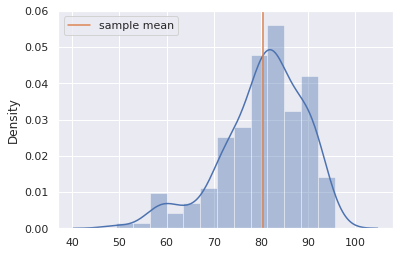

In [8]:
sns.distplot(grades)
plt.plot([np.mean(grades), np.mean(grades)], [0, 0.07], label = 'sample mean')
plt.ylim(0, 0.06)
plt.legend();

### Question 2b

Now, use the right parameters to call our `bootstrap` method to obtain the sample mean $\bar{X}$ for $m$ different bootstrap samples $\{x_i\}$. 

**Note**: Re-running the below cell will give us a different mean and variance each time (Why?).

<!--
BEGIN QUESTION
name: q2b
-->

Mean of all bootstrap sample means: 80.47202565129572 
Variance of bootstrap sample means: 0.38093063891231815


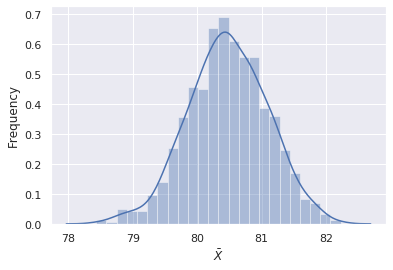

In [9]:
m = 1000  # the number of resamples 
boot_pop = np.array(grades["Grade"])

boot_sample_means = bootstrap(boot_pop, np.mean, simple_resample, m)

boot_mean_mean = np.mean(boot_sample_means)
boot_var_mean = np.var(boot_sample_means)
print('Mean of all bootstrap sample means:', boot_mean_mean, '\nVariance of bootstrap sample means:', boot_var_mean)
sns.distplot(boot_sample_means)
plt.xlabel(r"$\bar{X}$")
plt.ylabel("Frequency");

In [10]:
grader.check("q2b")

All tests passed!

How do your results compare to the true midterm distribution with $\mu=80.1$ and $\sigma=9.20?$

### Question 2c

Now, use the right parameters to call our `bootstrap` method to obtain the standard deviation $\sqrt{\frac{1}{n}\sum_{i=1}^{n} (x_i-\bar{X})^2}$ for $m$ different bootstrap samples $\{x_i\}$. You should use `np.std`.

<!--
BEGIN QUESTION
name: q2c
-->

Mean of bootstrap sample SDs: 8.702864020585144 
Variance of bootstrap sample SDs: 0.2494347204379899


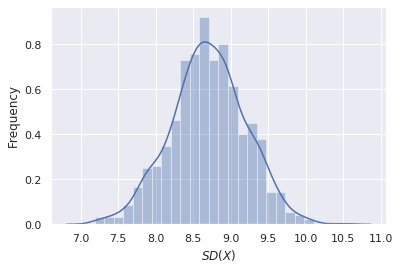

In [11]:
m = 1000
boot_pop = np.array(grades["Grade"])

boot_sample_std = bootstrap(boot_pop, np.std, simple_resample, m)

boot_mean_std = np.mean(boot_sample_std)
boot_var_std = np.var(boot_sample_std)
print('Mean of bootstrap sample SDs:', boot_mean_std, '\nVariance of bootstrap sample SDs:', boot_var_std)
sns.distplot(boot_sample_std)
plt.xlabel(r"$SD(X)$")
plt.ylabel("Frequency");

In [12]:
grader.check("q2c")

All tests passed!

### Question 2d

Our bootstrap estimates were fairly accurate for the midterm grades, but this may not necessarily be the case when we sample from more complex distributions. In the following parts, we will create bootstrap estimates for the mean and standard deviation of an exponential population, as done in lecture.

Below is the probability density function (pdf) of the exponential distribution with $\lambda=\frac{1}{2}$. The exponential distribution has a neat property where the mean and standard deviation are both given by $\frac{1}{\lambda}$. That means for our exponential population, $\mu=2$ and $\sigma=2$.

![exponential distribution](exp.png)

A bootstrap population of 20 samples from the exponential distribution has been generated for you in `exp_pop`. Use the `bootstrap` function that you wrote below to find the sample mean $\bar{X}$ for 1000 bootstrap samples.

***Note***: We purposely set the random seed to 15 to generate a bootstrap population that results in a particularly bad estimate of the true mean in this part, but you will see in part (e) that there is a lot of variance in the bootstrap mean estimate depending on the bootstrap population that we sample from.

<!--
BEGIN QUESTION
name: q2d
-->

Mean of all bootstrap sample means: 1.3309705314423463 
Variance of bootstrap sample means: 0.1106030749286802


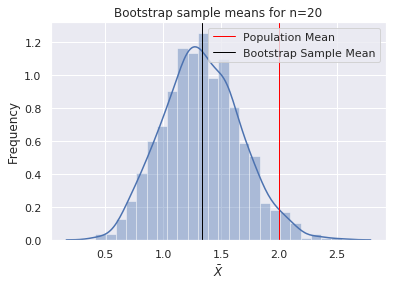

In [37]:
np.random.seed(15)

m = 1000
exp_pop = np.random.exponential(scale=2, size=20)

exp_boot_means = bootstrap(exp_pop, np.mean, simple_resample, m)

exp_boot_mean = np.mean(exp_boot_means)
exp_boot_var = np.var(exp_boot_means)
print('Mean of all bootstrap sample means:', exp_boot_mean, '\nVariance of bootstrap sample means:', exp_boot_var)
sns.distplot(exp_boot_means)
plt.axvline(x=2, label='Population Mean', c='red', linewidth=1)
plt.axvline(x=np.mean(exp_boot_means), label='Bootstrap Sample Mean', c='black', linewidth=1)
plt.title('Bootstrap sample means for n=20')
plt.xlabel(r"$\bar{X}$")
plt.ylabel("Frequency")
plt.legend();

In [38]:
grader.check("q2d")

All tests passed!

### Question 2e

Observe that the distribution of our bootstrapped sample means is not at all centered on the true population mean of the exponential distribution ($\mu=2$). Repeat the experiment done in part (d) for five different populations of size $n=20$ drawn from the Exponential ($\lambda = \frac{1}{2}$) distribution and plot the distributions side by side. How many of the distributions are centered near the true population mean?

(Note: This is a subtle point, but what we are plotting in this question is the distribution of several bootstrapped sample means, not the distribution of a single bootstrapped resample. We can only do this because we have access to the entire population, which we typically don't.)

**Hint:** You may want to look at the documentation of `np.random.exponential` to determine how to set its parameters.

<!--
BEGIN QUESTION
name: q2e
-->

In [23]:
m = 1000
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
plt.tight_layout()
for i in range(5):
    exp_pop = ...
    exp_boot_means = ...
    axs[i].hist(exp_boot_means) 
    
    axs[i].axvline(x=np.mean(exp_boot_means), label='Bootstrap Sample Mean', c='black', linewidth=2)
    axs[i].axvline(2, color='r', label='Population Mean', c='r', linewidth=2)
    axs[i].legend()
    axs[i].set_title('Bootstrap sample means for n=20')
    axs[i].set_xlabel(r"$\bar{X}$")
    axs[i].set_ylabel("Frequency");

In [ ]:
grader.check("q2e")

### Question 2f

There seems to be a lot of variance in the bootstrap sample mean distributions, but this may simply be caused by our small sample size. Plot the sample mean distribution for five different Exponential ($\lambda = \frac{1}{2}$) populations, but increase the sample size of each bootstrap population to $n=200$. Do your results differ from part (e)? 

<!--
BEGIN QUESTION
name: q2f
-->

In [25]:
m = 1000
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
plt.tight_layout()
for i in range(5):
    exp_pop = ...
    exp_boot_means = ...
    axs[i].hist(exp_boot_means) 
    axs[i].axvline(2, color='r', label='Population Mean')
    axs[i].legend()
    axs[i].set_title('Bootstrap sample means for n=200')
    axs[i].set_xlabel(r"$\bar{X}$")
    axs[i].set_ylabel("Frequency");

In [ ]:
grader.check("q2f")

What you should take away from this is that the usefulness of the bootstrap as a tool in inference depends greatly on the shape of the population distribution. Tricky distributions will lead to less-than-stellar bootstrap results.

## Question 3
Now let's use the bootstrap method to analyze more sophisticated estimators – the coefficients of linear models.

Let's use the `mpg` dataset from `seaborn` that we looked at in an earlier lab.

In [13]:
mpg = sns.load_dataset('mpg')
mpg = mpg.dropna()
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


Let's start by looking at the relationship between `horsepower` and `mpg`.

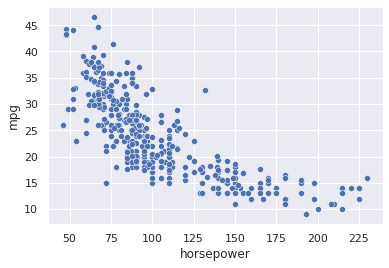

In [14]:
sns.scatterplot(mpg['horsepower'], mpg['mpg']);

It should be clear that a line of best fit going through these points would not pass through the origin, but for the sake of simplicity, let's start by building a simple linear model **without an intercept term** to model `mpg` as a function of `horsepower`. We will assume there is some true slope $\theta^*$ that we are trying to estimate, such that

$$\text{mpg} = \theta^* \cdot \text{horsepower}$$

Our prediction for `mpg` is then

$$\hat{\text{mpg}} = \theta \cdot \text{horsepower}$$

In Homework 5, you showed that the value of $\hat{\theta}$ that minimized average squared loss for this model is given by

$${\hat{\theta}} = \frac{\sum x_iy_i}{\sum x_i^2}$$

We describe the above $\hat{\theta}$ as the **least squares estimator** for $\theta^*$.

### Question 3a

Below, implement the function `single_parameter_estimator`, which takes in a dataset `d` and returns the least squares estimate for $\theta^*$ defined above.

Note that in order to perform the bootstrap, we need to combine `x`, `y` into a $n \times 2$ array `d`. So `d[:,0]` is equivalent to `x`, and `d[:,1]` corresponds to `y`.

<!--
BEGIN QUESTION
name: q3a
-->

In [15]:
def single_parameter_estimator(d):
    """
    Args:
        d: A n*2 array which contains x and y. d[:,0] corresponds to x and d[:,1] to y.
        
    Returns:
        The optimal theta that minimizes average squared loss for this dataset and model
        .
    """
    return sum(d[:,0]* d[:,1]) / sum(d[:,0]**2)


data_3a = mpg[['horsepower', 'mpg']].values
single_parameter_estimator(data_3a)

0.17883983692103222

In [16]:
grader.check("q3a")

All tests passed!

Now, we can use our previous `bootstrap` function to obtain different bootstrap estimations for $\theta$:

In [17]:
replicates = 1000

boot_theta = bootstrap(data_3a, single_parameter_estimator, simple_resample, replicates)

boot_theta_mean = np.mean(boot_theta)
boot_theta_var = np.var(boot_theta)
print('mean of bootstrap theta:', boot_theta_mean, '\nvariance of bootstrap theta:', boot_theta_var)

mean of bootstrap theta: 0.17907663457965323 
variance of bootstrap theta: 4.4019302157242586e-05


Finally, let's plot the distribution of `boot_theta`.

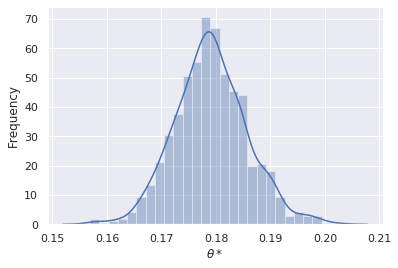

In [18]:
sns.distplot(boot_theta);
plt.xlabel(r"$\theta*$")
plt.ylabel("Frequency");

### Question 3b

As we saw in lecture, we can extend this procedure to a linear model with any number of coefficients. Let's now suppose we are trying to model `mpg` as a linear function of `horsepower`, `weight`, and `acceleration`, that contains an intercept term. We are looking to estimate $\theta_0^*, \theta_1^*, \theta_2^*,$ and $\theta_3^*$ in

$$\text{mpg} = \theta_0^* + \theta_1^* \cdot \text{horsepower} + \theta_2^* \cdot \text{weight} + \theta_3^* \cdot \text{acceleration} + \epsilon$$

After we find our estimated/fitted parameters, this model makes predictions using the formula
$$\text{predicted mpg} = \hat{\theta_0} + \hat{\theta_1} \cdot \text{horsepower} + \hat{\theta_2} \cdot \text{weight} + \hat{\theta_3} \cdot \text{acceleration}$$


If we want to bootstrap the sampling distribution of the estimators of multiple coefficients, it's probably best to use `scikit-learn`'s `LinearRegression` package to determine what the least squares estimates of our parameters are. Here's how we _could have_ written the `single_parameter_estimator` function above, using `scikit-learn` instead of hard-coding the optimal $\hat{\theta}$:

```py
def single_parameter_estimator_sk(d):
    """
    Args:
        d: A n*2 array which contains x and y. d[:,0] would be x, d[:,1] would be y.
        
    Returns:
        The optimal theta that minimizes average squared loss for this dataset and model
        .
    """
    model = lm.LinearRegression(fit_intercept = False)
    model.fit(d[:, 0].reshape(-1, 1), d[:, 1])
    return model.coef_[0]
```

Using the method described above, fill in the code for `four_parameter_estimator(d)`, that takes in a dataset `d` that has the same number of rows as the `mpg` dataset, and 4 columns (one each for `horsepower`, `acceleration`, `weight`, and `mpg`). It should return an **array** with 4 elements – the least squares estimates for all four model parameters (i.e. the model parameters that minimize average squared loss for this dataset).

To be explicit, the parameters we're solving for are the intercept term and the slopes on `horsepower`, `acceleration`, and `weight`. 

HINT: Try using `model.intercept_` and `model.coef_`.

<!--
BEGIN QUESTION
name: q3b
-->

In [20]:
def four_parameter_estimator(d):
    """
    Args:
        d: A n*4 array which contains X and y. 
        d[:, :3] contains our design matrix X, 
        d[:, 3] contains our true response values y.

    Returns:
        The optimal theta that minimizes average squared loss for this dataset and model
        .
    """
    model = lm.LinearRegression(fit_intercept = True)
    X = d[:,:3]
    Y = d[:, 3]
    model.fit(X,Y)
    return np.array([model.intercept_, model.coef_[0], model.coef_[1], model.coef_[2]])


data_3b = mpg[['horsepower', 'weight', 'acceleration', 'mpg']].values
four_parameter_estimator(data_3b)

array([ 4.56782929e+01, -4.74956153e-02, -5.78940259e-03, -2.06565785e-03])

In [21]:
grader.check("q3b")

All tests passed!

Now, it's time to use our `bootstrap` method to compute the estimated sampling distribution for all four of our parameters. Observe what happens when we call `bootstrap(data_3b, four_parameter_estimator, simple_resample, replicates)`:

In [22]:
bootstrap_multiple = bootstrap(data_3b, four_parameter_estimator, simple_resample, replicates)
bootstrap_multiple

array([[ 5.00219366e+01, -7.71388999e-02, -4.84882173e-03,
        -2.62305170e-01],
       [ 4.97005630e+01, -6.40241970e-02, -5.26619159e-03,
        -2.41456708e-01],
       [ 4.27843746e+01, -5.32062663e-02, -5.33162249e-03,
         1.16818928e-01],
       ...,
       [ 4.72686745e+01, -3.80133524e-02, -5.94611897e-03,
        -1.49291852e-01],
       [ 4.48979325e+01, -6.51238140e-02, -5.04131216e-03,
         1.14834644e-02],
       [ 4.09199142e+01, -2.92605204e-02, -5.92849284e-03,
         2.17781278e-01]])

In previous questions, the result of calling `bootstrap` was an array of length `replicates`. However, now it is a matrix of size `(replicates, 4)` since for each bootstrap resample, we are estimating four parameters, not one.

In `bootstrap_multiple`, column `i` contains the estimated values of $\theta_i^*$.

Below, we display a plot with the bootstrapped sampling distributions of all four parameter estimates.

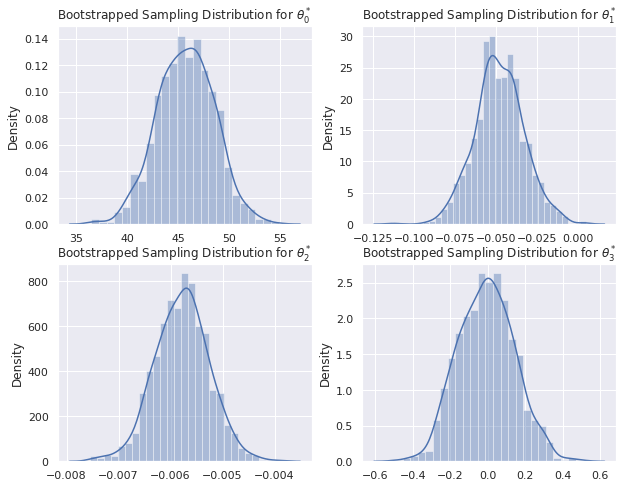

In [23]:
f, axs = plt.subplots(2,2,figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title(r'Bootstrapped Sampling Distribution for $\theta_{}^*$'.format(i))
    sns.distplot(bootstrap_multiple[:, i])

### Question 3c

Recall, we can use bootstrapped parameter estimates to create confidence intervals for the true model parameters.

Let's focus on the bootstrapped estimates for $\theta_3^*$ which corresponds to the model weight for `acceleration`. Below, set `left_endpt` and `right_endpt` to be the left and right endpoints for a **95% confidence interval** for the value of $\theta_3^*$.
- Hint: You will need to use `np.percentile`.

<!--
BEGIN QUESTION
name: q3c
-->

In [24]:
left_endpt = np.percentile([b[3] for b in bootstrap_multiple],2.5)
right_endpt = np.percentile([b[3] for b in bootstrap_multiple], 97.5)

left_endpt, right_endpt

(-0.27386977559305986, 0.2936001531243198)

In [25]:
grader.check("q3c")

All tests passed!

Below, we plot your confidence interval along with the distribution of bootstrapped estimates for $\theta_3^*$.

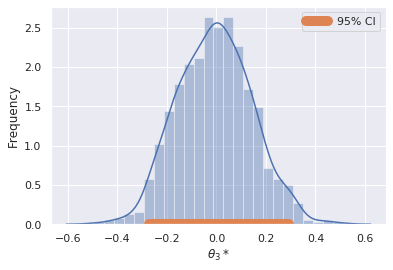

In [26]:
sns.distplot(bootstrap_multiple[:, 3]);
plt.plot([left_endpt, right_endpt], [0, 0], linewidth = 10, label = '95% CI');
plt.legend();
plt.xlabel(r"$\theta_3*$")
plt.ylabel("Frequency");

If you did Question 3c correctly, you should notice that 0 is in the confidence interval for $\theta_3^*$. Since this is the case, we would say we don't have enough evidence to reject the claim that the true slope is 0, i.e. that `acceleration` does not help explain `mpg` in a linear model.

## Question 4

That seems to be a little strange. Intuitively, we'd think that the acceleration of a car may impact its fuel economy. So why is it that the slope for acceleration in the previous question was found to be not significantly different than 0? Let's explore.

Firstly, let's look at a scatter plot between `acceleration` and `mpg`:

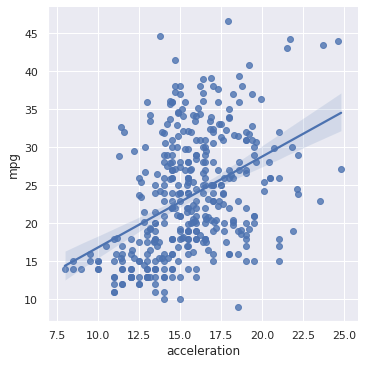

In [27]:
sns.lmplot(data = mpg,
           x = 'acceleration', 
           y = 'mpg');

Although the correlation is not particularly strong, we can see a slight positive correlation between `acceleration` and `mpg`:

In [28]:
mpg[['acceleration', 'mpg']].corr()

,acceleration,mpg
acceleration,1.000000,0.423329
mpg,0.423329,1.000000


This means, at the very least, that `acceleration` should provide some explanatory power when predicting `mpg`. So why was 0 in the confidence interval for the true slope on `acceleration` in the previous question?

Let's dig a little deeper. Let's look at the correlation between `horsepower`, `acceleration`, and `weight`.

In [29]:
mpg[['horsepower', 'acceleration', 'weight']].corr()

,horsepower,acceleration,weight
horsepower,1.000000,-0.689196,0.864538
acceleration,-0.689196,1.000000,-0.416839
weight,0.864538,-0.416839,1.000000


### Question 4a

What do you notice above? What does this have to do with 0 being in the 95% confidence interval for $\theta_3^*$ above?

<!--
BEGIN QUESTION
name: q4a
-->

Weight has a negative correlation with acceleration and mpg, while having a positive correlation with horsepower. 

### Question 4b

Let's now create a `two_parameter_estimator` that returns the estimates for the intercept and slope for the following model:

$$\text{mpg} = \theta_0^* + \theta_1^* \cdot \text{acceleration} + \epsilon$$

In [30]:
# This code is already filled in for you
def two_parameter_estimator(d):
    """
    Args:
        d: A n*2 array which contains X and y. 
        d[:, 0] contains our x,
        d[:, 1] contains our true y.

    Returns:
        The optimal theta that minimizes average squared loss for this dataset and model.
    """
    model = lm.LinearRegression(fit_intercept = True)
    model.fit(d[:, 0].reshape(-1, 1), d[:, 1])
    return np.append(model.intercept_, model.coef_)

data_4 = mpg[['acceleration', 'mpg']].values
two_parameter_estimator(data_4)

array([4.8332498 , 1.19762419])

In the following cell, set `bootstrap_4` to a `nx2` array that contains the results of calling our `bootstrap` method on the above estimator and data.
<!--
BEGIN QUESTION
name: q4b
-->

In [31]:
bootstrap_4 = bootstrap(data_4, two_parameter_estimator, simple_resample, replicates)
bootstrap_4

array([[2.22793543, 1.38877156],
       [4.89456058, 1.20679834],
       [1.54927391, 1.39890736],
       ...,
       [6.15753077, 1.0921803 ],
       [5.1531588 , 1.23340427],
       [6.85387855, 1.09333371]])

In [32]:
grader.check("q4b")

All tests passed!

Let's take a look at the distribution of the acceleration weight, $\theta_1^*$, for our new one parameter model. Notice that 0 is no longer in the 95% confidence interval after we removed weight and horsepower from the model!

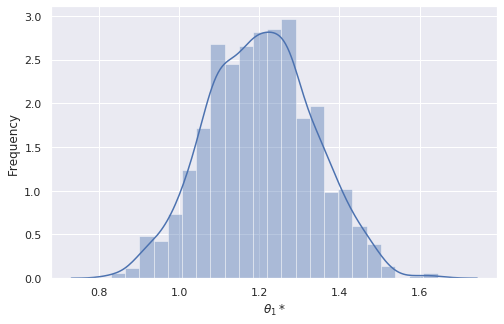

In [33]:
plt.figure(figsize = (8, 5))
sns.distplot(bootstrap_4[:, 1]);
plt.xlabel(r"$\theta_1*$");
plt.ylabel("Frequency");

### Question 4c

We could have alternatively caught the collinearity in our model features by thinking about their physical meaning. Suppose that we can calculate the horsepower of a car as 
$$hp = F\frac{d}{t}$$ where $F$ is the force in pounds and we set $d$ and $t$ to be constant. 

How can we use this fact and [Newton's Second Law](https://en.wikipedia.org/wiki/Newton%27s_laws_of_motion#Newton's_second_law) to explain the negative correlation between `weight` and `acceleration`?

<!--
BEGIN QUESTION
name: q4c
-->

_Type your answer here, replacing this text._

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [34]:
grader.check_all()

q1:

    All tests passed!
    

q2a:

    All tests passed!
    

q2b:

    All tests passed!
    

q2c:

    All tests passed!
    

q2d:

    
    0 of 1 tests passed
    
    
    Tests failed:
    
           tests/q2d.py

Test result:
Trying:
    np.isclose(exp_boot_mean, 1.3309705)
Expecting:
    True
**********************************************************************
Line 1, in tests/q2d.py 0
Failed example:
    np.isclose(exp_boot_mean, 1.3309705)
Exception raised:
    Traceback (most recent call last):
      File "/opt/conda/lib/python3.8/doctest.py", line 1336, in __run
        exec(compile(example.source, filename, "single",
      File "<doctest tests/q2d.py 0[0]>", line 1, in <module>
        np.isclose(exp_boot_mean, 1.3309705)
    NameError: name 'exp_boot_mean' is not defined

    
    
    
    

q2e:

    
    0 of 1 tests passed
    
    
    Tests failed:
    
           tests/q2e.py

Test result:
Trying:
    len(exp_boot_means) == m
Expecting:
    True
**********************************************************************
Line 1, in tests/q2e.py 0
Failed example:
    len(exp_boot_means) == m
Exception raised:
    Traceback (most recent call last):
      File "/opt/conda/lib/python3.8/doctest.py", line 1336, in __run
        exec(compile(example.source, filename, "single",
      File "<doctest tests/q2e.py 0[0]>", line 1, in <module>
        len(exp_boot_means) == m
    NameError: name 'exp_boot_means' is not defined

    
    
    
    

q2f:

    
    0 of 1 tests passed
    
    
    Tests failed:
    
           tests/q2f.py

Test result:
Trying:
    len(exp_boot_means) == m
Expecting:
    True
**********************************************************************
Line 1, in tests/q2f.py 0
Failed example:
    len(exp_boot_means) == m
Exception raised:
    Traceback (most recent call last):
      File "/opt/conda/lib/python3.8/doctest.py", line 1336, in __run
        exec(compile(example.source, filename, "single",
      File "<doctest tests/q2f.py 0[0]>", line 1, in <module>
        len(exp_boot_means) == m
    NameError: name 'exp_boot_means' is not defined

    
    
    
    

q3a:

    All tests passed!
    

q3b:

    All tests passed!
    

q3c:

    All tests passed!
    

q4b:

    All tests passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export("lab13_fixed.ipynb", pdf=False)